In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [2]:
df = pd.read_csv('monthly_milk_production.csv',index_col='Date',parse_dates=True)

In [3]:
df.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


<Axes: xlabel='Date'>

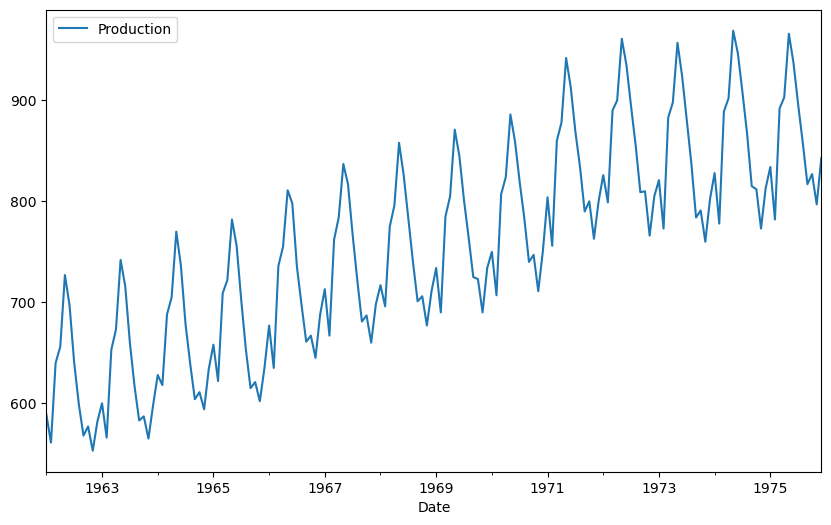

In [4]:
df.plot(figsize=(10,6))

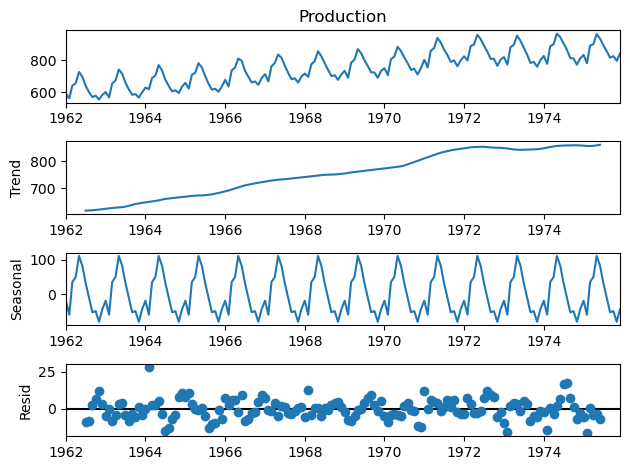

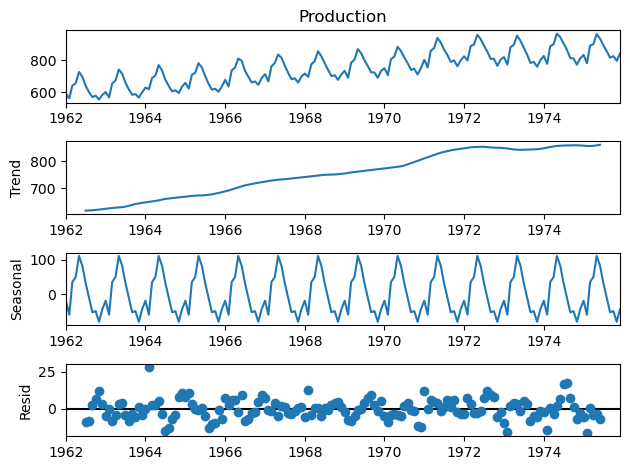

In [5]:
#now to know more about the data like the seasonality patterns etc we do this
graph = seasonal_decompose(df['Production'])
graph.plot()

In [6]:
df.shape

(168, 1)

In [7]:
train = df.iloc[:156]
test = df.iloc[156:]

In [8]:
scaler = MinMaxScaler()

In [9]:
scaler.fit(train)
scaled_train=scaler.transform(train)
scaled_test=scaler.transform(test)

In [10]:
#now important step
#converting data to what lstm can use
n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train,scaled_train,length=n_input,batch_size=1)


In [11]:
model = Sequential()
model.add(LSTM(100,activation='relu',input_shape=(n_input,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(generator,epochs=50)

Epoch 1/50
144/144 [==============================] - 4s 9ms/step - loss: 0.0395
Epoch 2/50
144/144 [==============================] - 1s 9ms/step - loss: 0.0223
Epoch 3/50
144/144 [==============================] - 1s 8ms/step - loss: 0.0172
Epoch 4/50
144/144 [==============================] - 1s 8ms/step - loss: 0.0088
Epoch 5/50
144/144 [==============================] - 1s 7ms/step - loss: 0.0085
Epoch 6/50
144/144 [==============================] - 1s 8ms/step - loss: 0.0071
Epoch 7/50
109/144 [=====================>........] - ETA: 0s - loss: 0.0056

In [ ]:
loss_graph = model.history.history['loss']
plt.plot(range(len(loss_graph)),loss_graph)

In [ ]:
# making predictions
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)
     
test['Predictions'] = true_predictions
     
test.plot(figsize=(14,5))